In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from astropy.io import fits
from astropy.nddata import CCDData
import astropy.units as u
from astropy.modeling import models, fitting
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval, ManualInterval
import h5py 
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator
import cmcrameri.cm as cmcm
from juanfit import SpectrumFitSingle, gaussian
from specutils.utils.wcs_utils import vac_to_air, air_to_vac
from scipy import ndimage
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

In [2]:
red_path = "../../src/EclipseSpectra2017/MikesData/VaderEclipseDayRed2017aug21/"

In [3]:
with h5py.File("../../sav/Eclipse/Bias/master_bias_dc_red_1s_proto.h5", 'r') as hf:
    bias_dc_red_1s = hf['image'][:]


In [4]:

helium_im_collection = ImageFileCollection(red_path,
                            glob_include="HeliumrRedpoint01s_920*.fit")
helium_im_df = helium_im_collection.summary.to_pandas()

In [5]:
helium_image_cube = np.zeros((1040,1392,10))

for ii, row_ in helium_im_df.iterrows():
    helium_image_cube[:,:,ii] = CCDData.read(os.path.join(red_path,row_["file"]),unit="adu").data - bias_dc_red_1s

(300.0, 750.0)

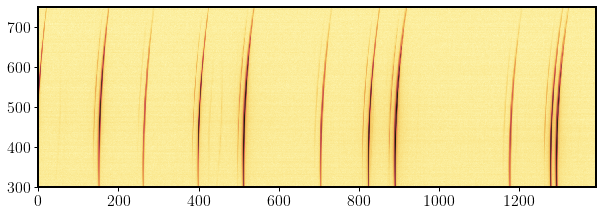

In [6]:
helium_im_aver = np.mean(helium_image_cube,axis=2)
yaxis_slice = slice(300,750)
norm = ImageNormalize(helium_im_aver, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.axis("scaled")
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

(1285.0, 1300.0)

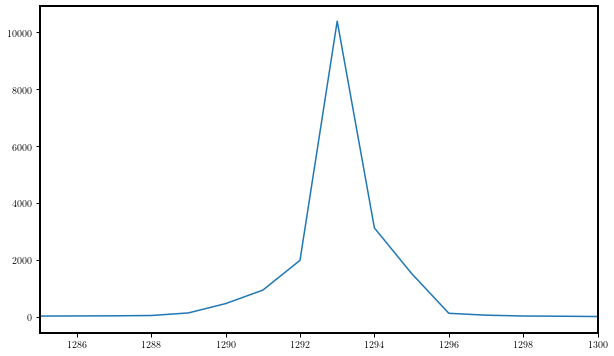

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.arange(1392), np.mean(helium_im_aver[300:305,:],axis=0))
ax.set_xlim(1285,1300)

In [8]:
helium_im_aver.shape

(1040, 1392)

In [9]:
class TraceSingleCurvature:
    def __init__(self,image, init_start, init_end, xarray = None,ybin=5,plot_fit=None):
        self.nbins = int(image.shape[0]/ybin)
        self.xpos = np.zeros(self.nbins)
        self.xwidth = np.zeros(self.nbins)
        self.xpos_err = np.zeros(self.nbins)
        self.xwidth_err = np.zeros(self.nbins)
        if xarray is None:
            self.xarray = np.arange(image.shape[1])
        
        self.wvl_region_half_length = int(np.ceil((init_end - init_start)/2))
        first_bin_slice = slice(init_start,init_end)
        first_bin = np.mean(image[:ybin,first_bin_slice],axis=0)
        
        xpos_guess = init_start + np.argmax(first_bin)
        popt, pcov = curve_fit(gaussian_bg,xdata=self.xarray[first_bin_slice],ydata=first_bin, 
                    p0=[self.xarray[xpos_guess], first_bin[xpos_guess - first_bin_slice.start]*2, 2, 0])

        self.xpos[0] = popt[0]
        self.xpos_err[0] = np.sqrt(pcov[0,0])
        self.xwidth[0] = popt[2]
        self.xwidth_err[0] = np.sqrt(pcov[2,2])

        for ii in range(1,self.nbins):
            ii_slice = slice(int(np.rint(self.xpos[ii - 1]) - self.wvl_region_half_length),
                            int(np.rint(self.xpos[ii - 1]) + self.wvl_region_half_length))
            ii_bin = np.mean(image[int(ii*ybin):int((ii+1)*ybin),ii_slice],axis=0)
            xpos_guess = ii_slice.start + np.argmax(ii_bin)

            popt, pcov = curve_fit(gaussian_bg,xdata=self.xarray[ii_slice],ydata=ii_bin, 
                    p0=[self.xarray[xpos_guess], ii_bin[xpos_guess - ii_slice.start]*2, 2, 0])

            self.xpos[ii] = popt[0]
            self.xpos_err[ii] = np.sqrt(pcov[0,0])
            self.xwidth[ii] = popt[2]
            self.xwidth_err[ii] = np.sqrt(pcov[2,2])

            if plot_fit is not None:
                if ii in plot_fit:
                    fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
                    ax.step(self.xarray[ii_slice], ii_bin,where="mid")
                    ax.plot(np.linspace(self.xarray[ii_slice][0], self.xarray[ii_slice][-1],50),
                            gaussian_bg(np.linspace(self.xarray[ii_slice][0], self.xarray[ii_slice][-1],50), 
                            *popt))
                    ax.text(0.02,0.97,r"$\Delta \lambda = {:.2f} \pm {:.2f}$".format(popt[2],self.xwidth_err[ii]),fontsize=16,transform=ax.transAxes,
                            va="top",ha="left")

        
def gaussian_bg(wvl, line_wvl, int_total, fwhm, bg):
    return gaussian(wvl, line_wvl=line_wvl, int_total=int_total, fwhm=fwhm) + bg




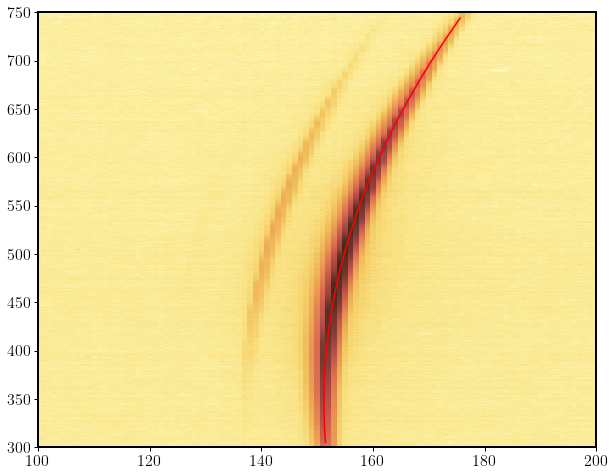

In [10]:
test_1 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=145,init_end=157)


fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_1_curve = test_1.xpos
test_1_ypix = np.arange(302,750,5)
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(100,200)

test_1_spl = UnivariateSpline(test_1_ypix, test_1_curve)
ax.plot(test_1_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [11]:
test_2 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=255,init_end=267)

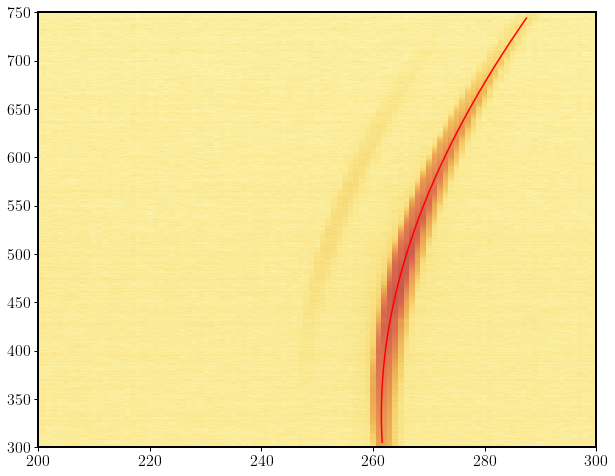

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_2_curve = test_2.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(200,300)

test_2_spl = UnivariateSpline(test_1_ypix, test_2_curve)
ax.plot(test_2_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [13]:
test_3 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=393,init_end=403)

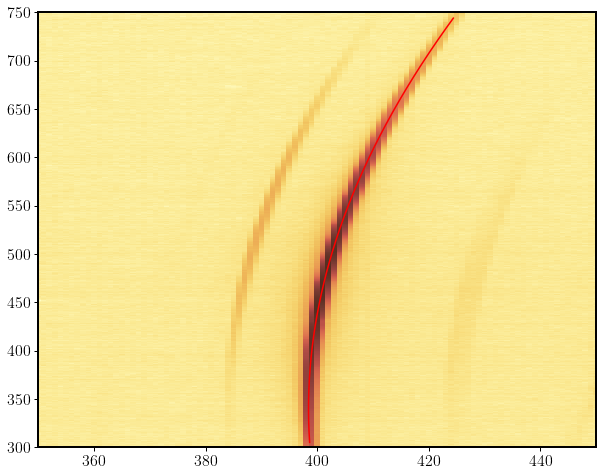

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_3_curve = test_3.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(350,450)

test_3_spl = UnivariateSpline(test_1_ypix, test_3_curve)
ax.plot(test_3_spl(np.arange(305,745)),np.arange(305,745),color="red")

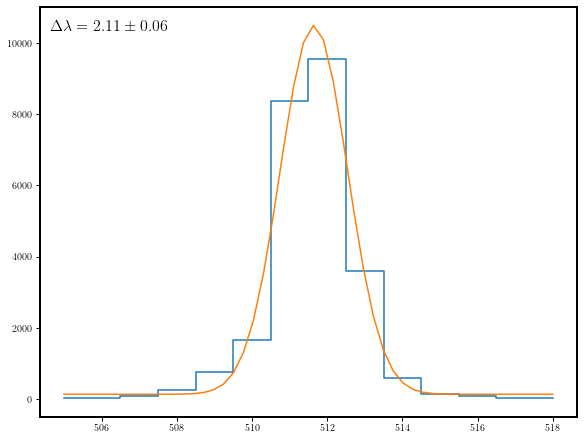

In [83]:
test_4 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=506,init_end=520,plot_fit=[10])

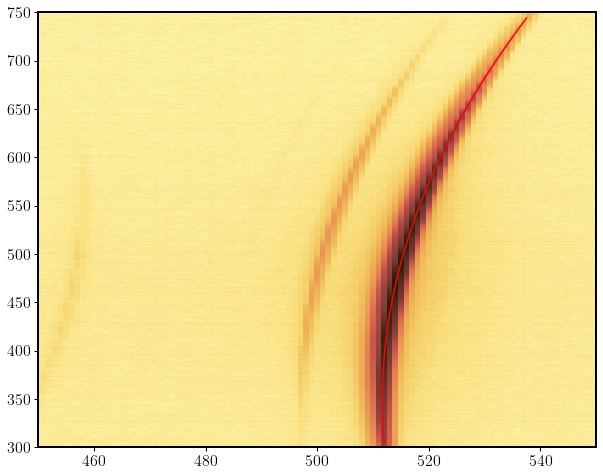

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_4_curve = test_4.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(450,550)

test_4_spl = UnivariateSpline(test_1_ypix, test_4_curve)
ax.plot(test_4_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [17]:
with h5py.File("../../sav/Eclipse/InstWidth/HeI_D3_2_width_red_curcorr.h5", 'r') as hf:
    HeI_D3_fwhm_curcorr = hf["HeI_D3_fwhm"][:][:,0]
    HeI_D3_fwhm_curcorr_err = hf["HeI_D3_fwhm_err"][:][:,0]

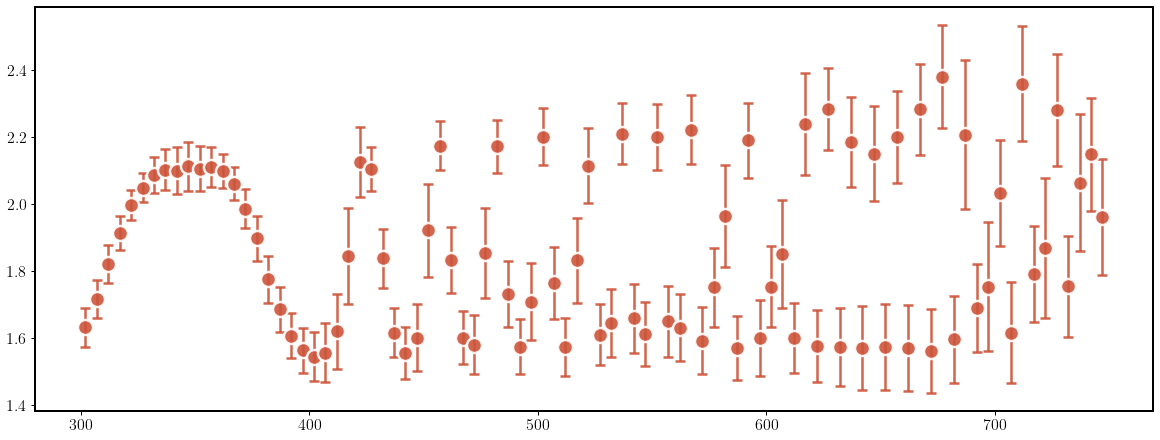

In [18]:
fig, ax = plt.subplots(figsize=(16,6),constrained_layout=True)
ax.errorbar(test_1_ypix,test_4.xwidth,test_4.xwidth_err,
            color="#CC543A",ls="none",marker="o",
            markersize=15,capsize=5,lw=2.5,zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.9,capthick=2.5)
ax.tick_params(labelsize=16)

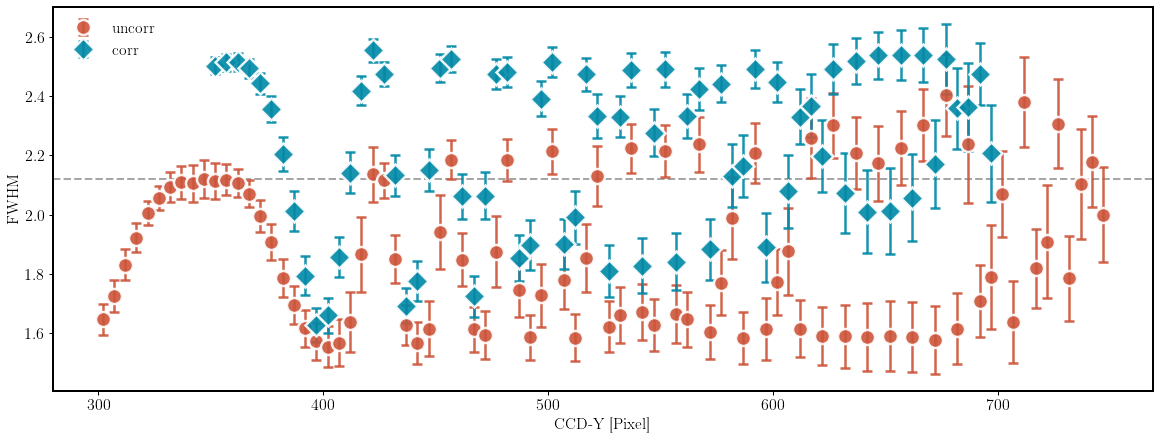

In [85]:
fig, ax = plt.subplots(figsize=(16,6),constrained_layout=True)
ax.errorbar(test_1_ypix,test_4.xwidth,test_4.xwidth_err,
            color="#CC543A",ls="none",marker="o",
            markersize=15,capsize=5,lw=2.5,zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.9,capthick=2.5,label=r"uncorr")
ax.errorbar(np.arange(352, 700, 5), HeI_D3_fwhm_curcorr, HeI_D3_fwhm_curcorr_err, 
            color="#0089A7",ls="none",marker="D",
            markersize=15,capsize=5,lw=2.5,zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.9,capthick=2.5,label=r"corr")
ax.tick_params(labelsize=16)
ax.set_ylabel("FWHM",fontsize=16)
ax.set_xlabel("CCD-Y [Pixel]",fontsize=16)
ax.axhline(2.12,color="grey",ls="--",lw=2,alpha=0.7,zorder=0)
plt.legend(fontsize=16,loc="upper left",frameon=False)

In [20]:
test_5 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=697,init_end=709)

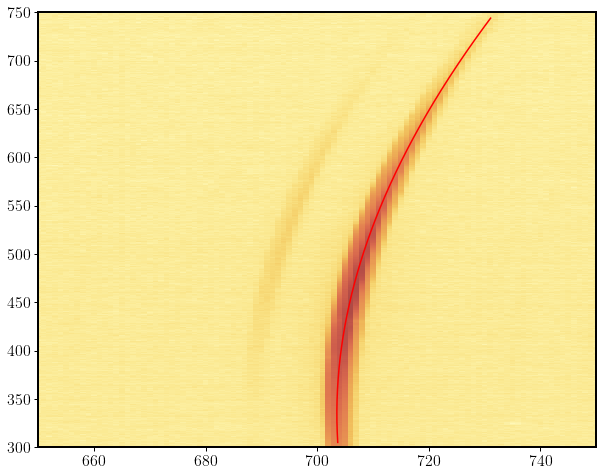

In [88]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_5_curve = test_5.xpos
# ax.step(test_5_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(650,750)

test_5_spl = UnivariateSpline(test_1_ypix, test_5_curve)
ax.plot(test_5_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [22]:
test_6 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=818,init_end=830)

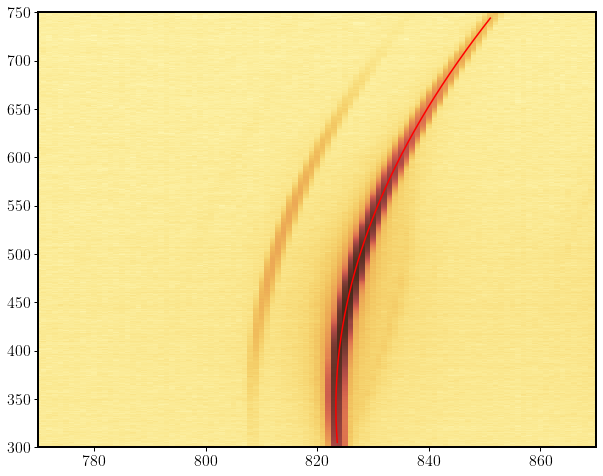

In [23]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_6_curve = test_6.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(770,870)

test_6_spl = UnivariateSpline(test_1_ypix, test_6_curve)
ax.plot(test_6_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [24]:
with h5py.File("../../sav/Eclipse/InstWidth/HeI_6678_2_width_red_curcorr.h5", 'r') as hf:
    HeI_6678_fwhm_curcorr = hf["HeI_6678_fwhm"][:][:,0]
    HeI_6678_fwhm_curcorr_err = hf["HeI_6678_fwhm_err"][:][:,0]

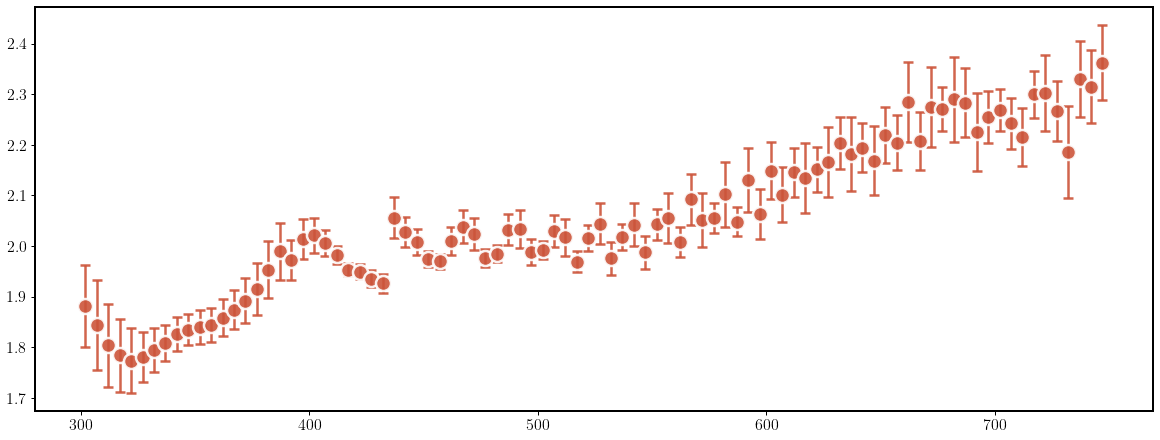

In [25]:
fig, ax = plt.subplots(figsize=(16,6),constrained_layout=True)
ax.errorbar(test_1_ypix,test_6.xwidth,test_6.xwidth_err,
            color="#CC543A",ls="none",marker="o",
            markersize=15,capsize=5,lw=2.5,zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.9,capthick=2.5)
ax.tick_params(labelsize=16)

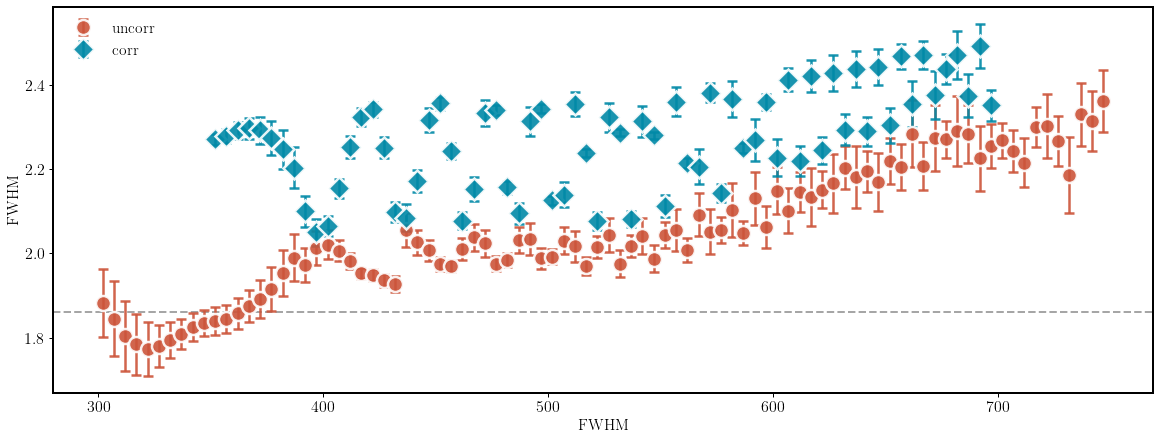

In [26]:
fig, ax = plt.subplots(figsize=(16,6),constrained_layout=True)
ax.errorbar(test_1_ypix,test_6.xwidth,test_6.xwidth_err,
            color="#CC543A",ls="none",marker="o",
            markersize=15,capsize=5,lw=2.5,zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.9,capthick=2.5,label="uncorr")
ax.errorbar(np.arange(352, 700, 5), HeI_6678_fwhm_curcorr, HeI_6678_fwhm_curcorr_err, 
            color="#0089A7",ls="none",marker="D",
            markersize=15,capsize=5,lw=2.5,zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.9,capthick=2.5,label=r"corr")
ax.tick_params(labelsize=16)
ax.set_ylabel("FWHM",fontsize=16)
ax.set_xlabel("",fontsize=16)
ax.axhline(1.86,color="grey",ls="--",lw=2,alpha=0.7,zorder=0)
plt.legend(fontsize=16,loc="upper left",frameon=False)

In [27]:
test_7 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=885,init_end=895)

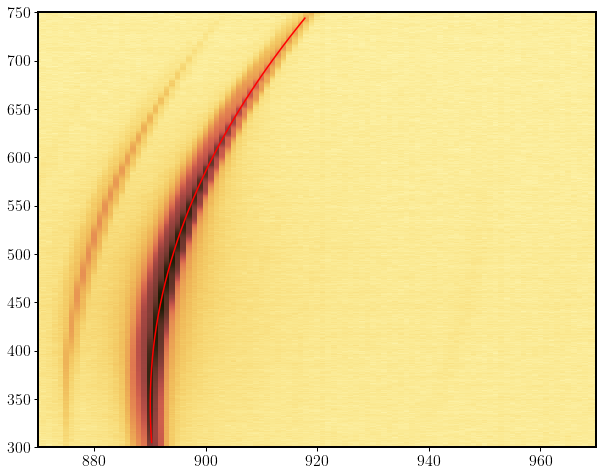

In [28]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_7_curve = test_7.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(870,970)

test_7_spl = UnivariateSpline(test_1_ypix, test_7_curve)
ax.plot(test_7_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [29]:
test_8 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=1169,init_end=1184)

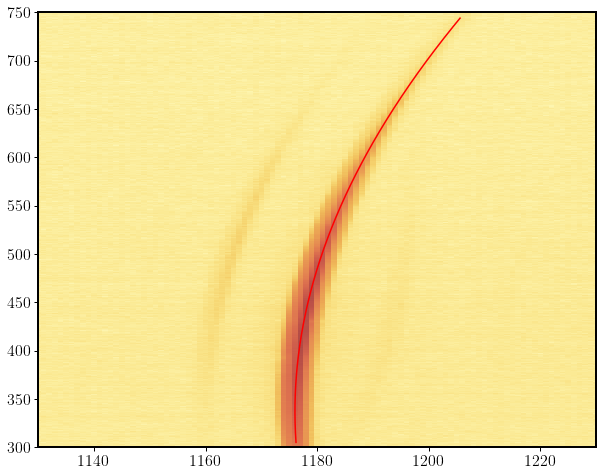

In [30]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_8_curve = test_8.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(1130,1230)

test_8_spl = UnivariateSpline(test_1_ypix, test_8_curve)
ax.plot(test_8_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [31]:
test_9 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=1270,init_end=1284)

In [32]:
test_10 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=1285,init_end=1300)

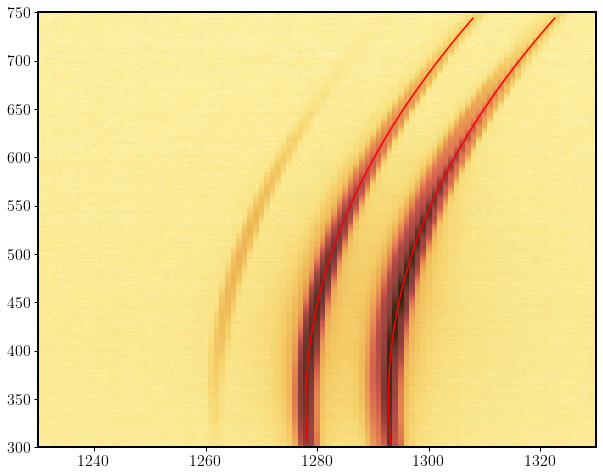

In [33]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_9_curve = test_9.xpos
test_10_curve = test_10.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(1230,1330)

test_9_spl = UnivariateSpline(test_1_ypix, test_9_curve)
test_10_spl = UnivariateSpline(test_1_ypix, test_10_curve)
ax.plot(test_9_spl(np.arange(305,745)),np.arange(305,745),color="red")
ax.plot(test_10_spl(np.arange(305,745)),np.arange(305,745),color="red")

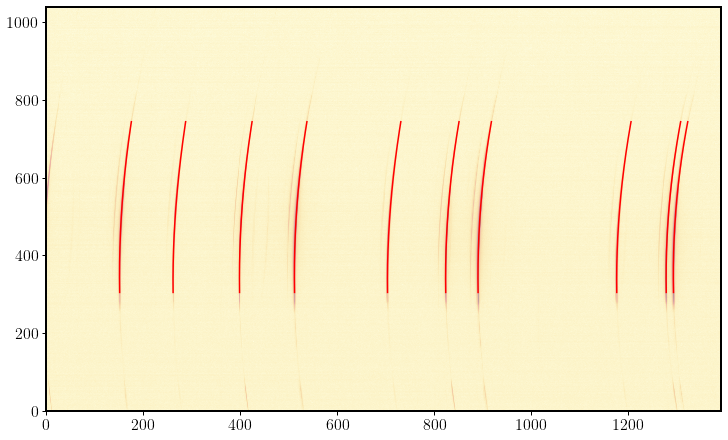

In [34]:
fig, ax = plt.subplots(figsize=(10,6),constrained_layout=True)
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True,alpha=0.5)
ax.tick_params(labelsize=16)

spls = (test_1_spl,test_2_spl,test_3_spl,test_4_spl,test_5_spl,
            test_6_spl,test_7_spl,test_8_spl,test_9_spl,test_10_spl)
for spl_ in spls :
    ax.plot(spl_(np.arange(305,745)),np.arange(305,745),color="red")

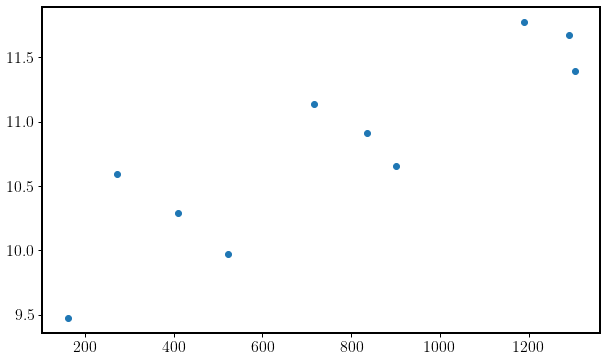

In [35]:
fig, ax = plt.subplots(figsize=(10,6))
xpos_y600 = np.array([spl_(600) for spl_ in spls])
xpos_y400 = np.array([spl_(400) for spl_ in spls])
xshift_y600 = xpos_y600 - xpos_y400
ax.scatter(xpos_y600, xshift_y600)
ax.tick_params(labelsize=16)

In [36]:
hydrogen_im_collection = ImageFileCollection(red_path,
                            glob_include="HydrogenRedpoint1s_947*.fit")
hydrogen_im_df = hydrogen_im_collection.summary.to_pandas()

In [37]:
hydrogen_image_cube = np.zeros((1040,1392,10))

for ii, row_ in hydrogen_im_df.iterrows():
    hydrogen_image_cube[:,:,ii] = CCDData.read(os.path.join(red_path,row_["file"]),unit="adu").data - bias_dc_red_1s

(300.0, 750.0)

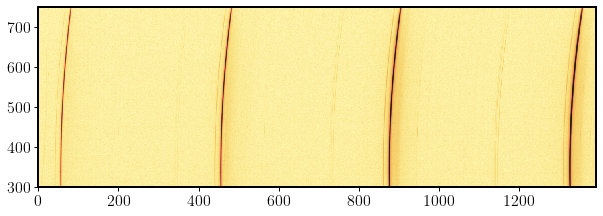

In [38]:
hydrogen_im_aver = np.mean(hydrogen_image_cube,axis=2)
yaxis_slice = slice(300,750)
norm_hydrogen = ImageNormalize(hydrogen_im_aver, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm_hydrogen,cmap=cmcm.lajolla, rasterized=True)
ax.axis("scaled")
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

(1320.0, 1335.0)

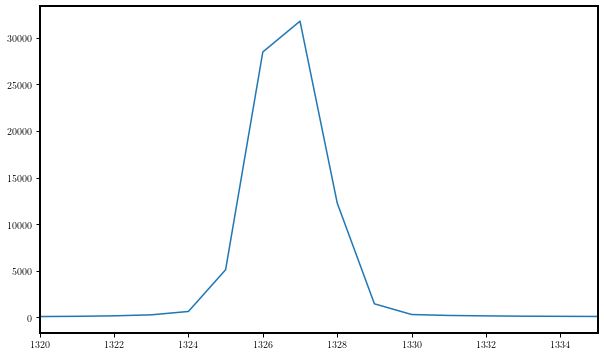

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.arange(1392), np.mean(hydrogen_im_aver[300:305,:],axis=0))
ax.set_xlim(1320,1335)

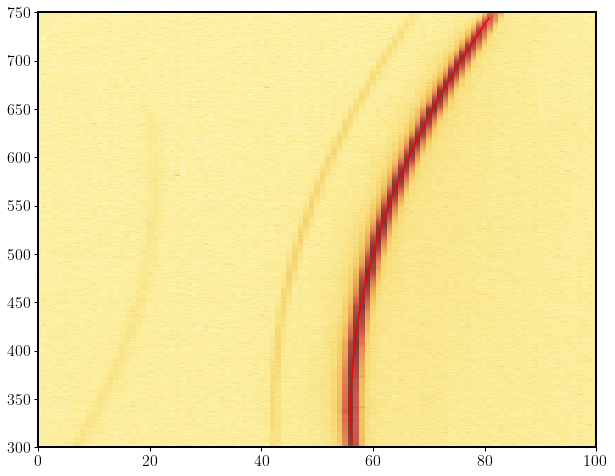

In [40]:
test_halpha1 = TraceSingleCurvature(hydrogen_im_aver[300:750,:],init_start=50,init_end=64)

fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm_hydrogen,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_halpha1_curve = test_halpha1.xpos
test_halpha1_ypix = np.arange(302,750,5)
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(0,100)

test_halpha1_spl = UnivariateSpline(test_halpha1_ypix, test_halpha1_curve)
ax.plot(test_halpha1_spl(np.arange(305,745)),np.arange(305,745),color="red")

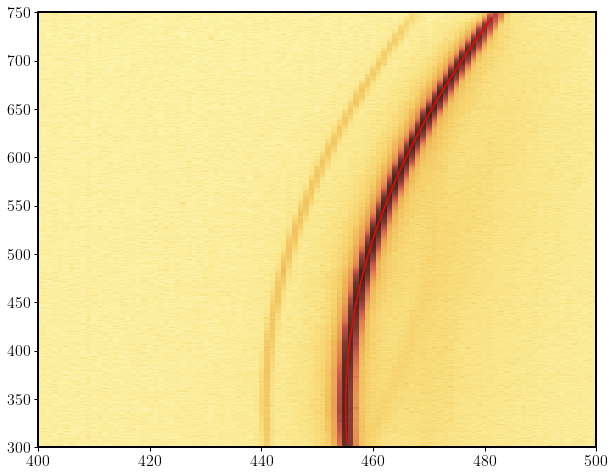

In [41]:
test_halpha2 = TraceSingleCurvature(hydrogen_im_aver[300:750,:],init_start=448,init_end=462)

fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm_hydrogen,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_halpha2_curve = test_halpha2.xpos
test_halpha2_ypix = np.arange(302,750,5)
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(400,500)

test_halpha2_spl = UnivariateSpline(test_halpha2_ypix, test_halpha2_curve)
ax.plot(test_halpha2_spl(np.arange(305,745)),np.arange(305,745),color="red")

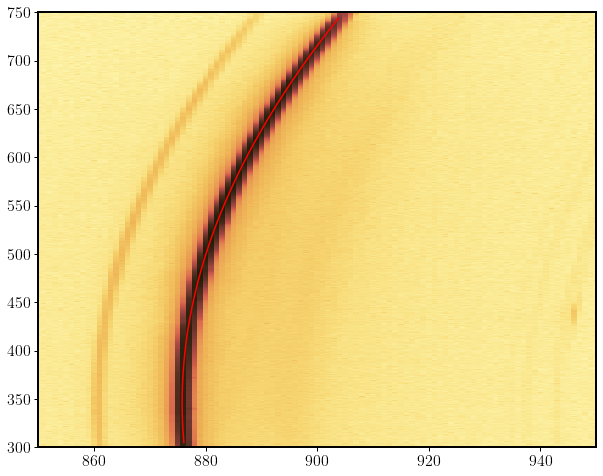

In [42]:
test_halpha3 = TraceSingleCurvature(hydrogen_im_aver[300:750,:],init_start=870,init_end=884)

fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm_hydrogen,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_halpha3_curve = test_halpha3.xpos
test_halpha3_ypix = np.arange(302,750,5)
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(850,950)

test_halpha3_spl = UnivariateSpline(test_halpha3_ypix, test_halpha3_curve)
ax.plot(test_halpha3_spl(np.arange(305,745)),np.arange(305,745),color="red")

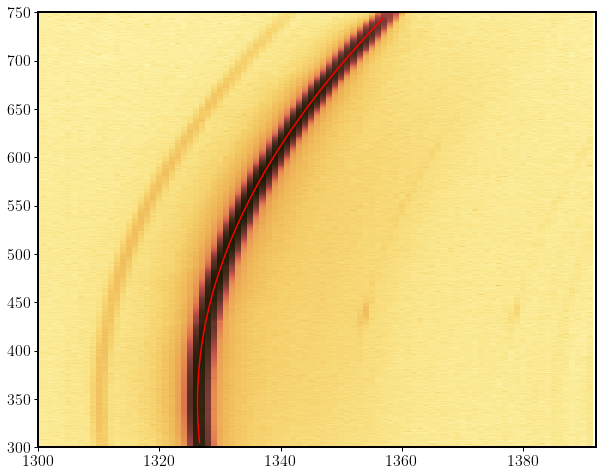

In [43]:
test_halpha4 = TraceSingleCurvature(hydrogen_im_aver[300:750,:],init_start=1320,init_end=1335)

fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm_hydrogen,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_halpha4_curve = test_halpha4.xpos
test_halpha4_ypix = np.arange(302,750,5)
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(1300,1392)

test_halpha4_spl = UnivariateSpline(test_halpha4_ypix, test_halpha4_curve)
ax.plot(test_halpha4_spl(np.arange(305,745)),np.arange(305,745),color="red")

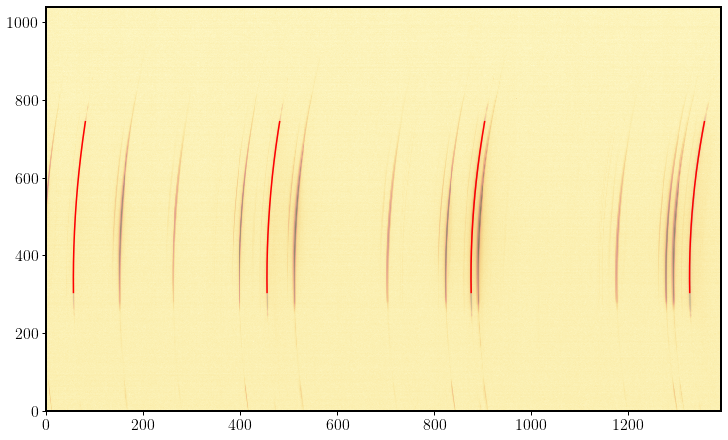

In [44]:
fig, ax = plt.subplots(figsize=(10,6),constrained_layout=True)
ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm_hydrogen,cmap=cmcm.lajolla, rasterized=True,alpha=0.5)
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True,alpha=0.5)
ax.tick_params(labelsize=16)

spls_halpha = (test_halpha1_spl,test_halpha2_spl,test_halpha3_spl,test_halpha4_spl)
for spl_ in spls_halpha :
    ax.plot(spl_(np.arange(305,745)),np.arange(305,745),color="red")

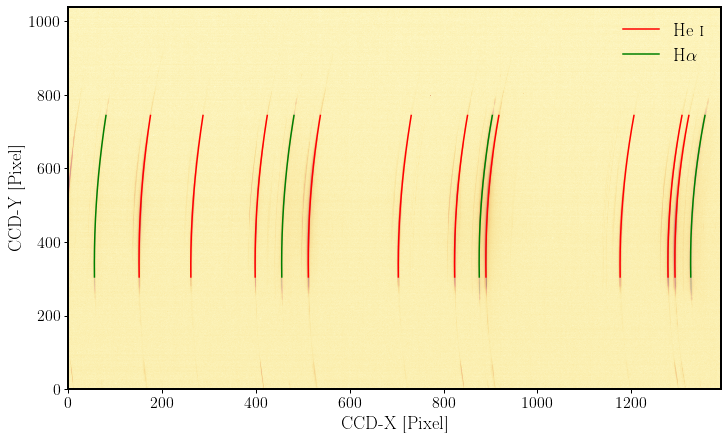

In [45]:
fig, ax = plt.subplots(figsize=(10,6),constrained_layout=True)
ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm_hydrogen,cmap=cmcm.lajolla, rasterized=True,alpha=0.5)
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True,alpha=0.5)
ax.tick_params(labelsize=16)

spls_halpha = (test_halpha1_spl,test_halpha2_spl,test_halpha3_spl,test_halpha4_spl)
for ii, spl_ in enumerate(spls):
    ax.plot(spl_(np.arange(305,745)),np.arange(305,745),color="red",label=r"He \textsc{i}" if ii == 0 else None)
for ii, spl_ in enumerate(spls_halpha):
    ax.plot(spl_(np.arange(305,745)),np.arange(305,745),color="green",label=r"H$\alpha$" if ii == 0 else None)
plt.legend(fontsize=18,frameon=False,loc="upper right")
ax.set_xlabel("CCD-X [Pixel]",fontsize=18)
ax.set_ylabel("CCD-Y [Pixel]",fontsize=18)
plt.savefig(fname="../../figs/calib/curvature_red_test.png",format="png",dpi=150)

In [46]:
spls_all = (test_halpha1_spl, test_1_spl, test_2_spl, test_3_spl,
            test_halpha2_spl, test_4_spl, test_5_spl, test_6_spl,
            test_halpha3_spl, test_7_spl, test_8_spl, test_9_spl,
            test_10_spl, test_halpha4_spl)
ypos_tofit = np.tile(np.arange(305,745,dtype=np.float64),(14,1)).T
xpos_tofit = np.zeros_like(ypos_tofit,dtype=np.float64)
for ii, spl_ in enumerate(spls_all):
    xpos_tofit[:,ii] = spl_(ypos_tofit[:,ii])
xshift_tofit = xpos_tofit - xpos_tofit[95,:]

In [47]:
xpos_tofit

array([[  56.22570049,  151.49703375,  261.66265698, ..., 1278.23717981,
        1293.16125024, 1326.6066515 ],
       [  56.21561998,  151.48434786,  261.65277172, ..., 1278.22325332,
        1293.14469897, 1326.59082827],
       [  56.20584676,  151.47197014,  261.64323387, ..., 1278.209697  ,
        1293.12851635, 1326.57539619],
       ...,
       [  80.55510275,  175.37795907,  287.26301532, ..., 1307.62299695,
        1322.26691809, 1356.59549076],
       [  80.67558712,  175.5004037 ,  287.38304405, ..., 1307.77226393,
        1322.4198718 , 1356.74811832],
       [  80.79636172,  175.62315862,  287.50331971, ..., 1307.92190764,
        1322.57323271, 1356.90112565]])

In [48]:
chebyshev2d_init = models.Chebyshev2D(x_degree=1,y_degree=2)
fit_chebyshev2d = fitting.LevMarLSQFitter()
chebyshev2d_p = fit_chebyshev2d(chebyshev2d_init,xpos_tofit, ypos_tofit, xshift_tofit)

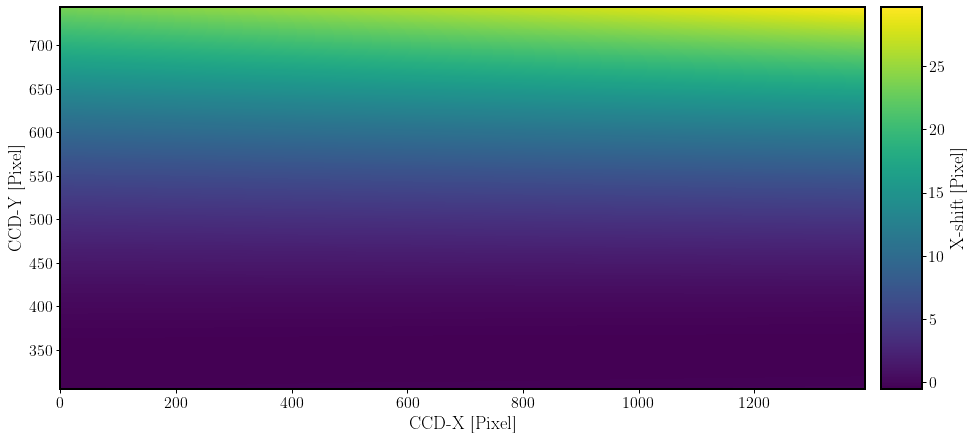

In [49]:
ypos_plot, xpos_plot = np.mgrid[305:745,:1392]
fig, ax = plt.subplots(figsize=(12,6),constrained_layout=True)
im = ax.pcolormesh(xpos_plot, ypos_plot, chebyshev2d_p(xpos_plot, ypos_plot),rasterized=True)

testx_slice = slice(100,200)
testy_slice = slice(350,700)

test_rectangle = Rectangle((testx_slice.start, testy_slice.start), 
                    testx_slice.stop - testx_slice.start,
                    testy_slice.stop - testy_slice.start,
                    edgecolor="red",facecolor='none',lw=2)

# ax.add_patch(test_rectangle)

ax.tick_params(labelsize=16)
ax.set_xlabel("CCD-X [Pixel]",fontsize=18)
ax.set_ylabel("CCD-Y [Pixel]",fontsize=18)
clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('X-shift [Pixel]',fontsize=18)
plt.savefig(fname="../../figs/calib/curvature_2d_fit.png",format="png",dpi=150,bbox_inches="tight")

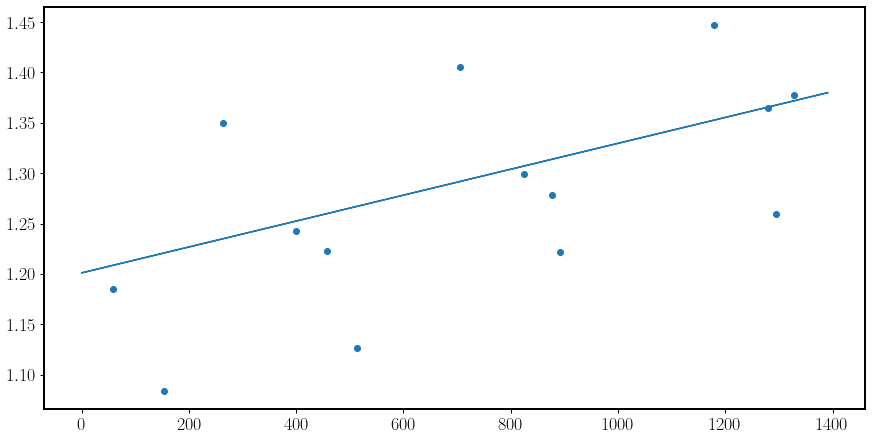

In [50]:
fig, ax = plt.subplots(figsize=(12,6),constrained_layout=True)
ax.step(np.arange(1392), chebyshev2d_p(np.arange(1392), 446*np.ones(1392)))
ax.scatter(xpos_tofit[141,:],xshift_tofit[141,:])
ax.tick_params(labelsize=18)

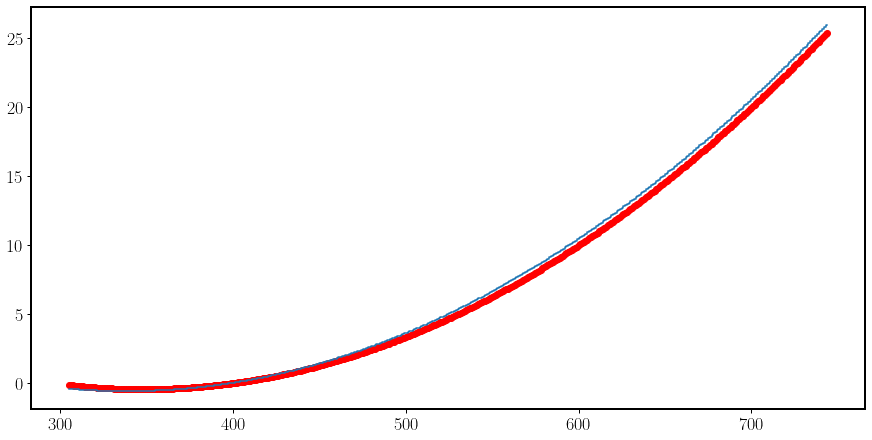

In [51]:
fig, ax = plt.subplots(figsize=(12,6),constrained_layout=True)
ax.step(np.arange(305,745), chebyshev2d_p(xpos_tofit[:,5], np.arange(305,745)))
ax.scatter(ypos_tofit[:,5],xshift_tofit[:,5],color="red")
ax.tick_params(labelsize=18)

In [52]:
# class ChebyShevMappinig:
#     def __init__(self,chebyshev_model):
#         self.chebyshev_model = chebyshev_model

#     def shift_func(self, output_coords):
#         return (output_coords[0] - self.chebyshev_model(output_coords[0],output_coords[1]), output_coords[1])

In [53]:
# def shift_func(output_coords):
#     return (output_coords[0], 
#             output_coords[1] + chebyshev2d_p(output_coords[1]+100,output_coords[0]+350))

In [54]:
# helium_trans_test = ndimage.geometric_transform(helium_im_aver[testy_slice, testx_slice],shift_func)

In [55]:
# fig, ax = plt.subplots(figsize=(4,8),constrained_layout=True)
# ax.pcolormesh(np.arange(testx_slice.start,testx_slice.stop),np.arange(testy_slice.start,testy_slice.stop),
#             helium_trans_test,norm=norm,cmap=cmcm.lajolla,rasterized=True)

In [56]:
testx_slice_mapcoor = slice(40,1350)
testy_slice_mapcoor = slice(350,700)
ypos_map_coordinate, xpos_map_coordinate = np.mgrid[testy_slice_mapcoor,testx_slice_mapcoor]
xpos_map_coordinate = xpos_map_coordinate + chebyshev2d_p(xpos_map_coordinate, ypos_map_coordinate)

xpos_map_coordinate = xpos_map_coordinate - testx_slice_mapcoor.start
ypos_map_coordinate = ypos_map_coordinate - testy_slice_mapcoor.start


In [57]:
helium_trans_mapcoor = ndimage.map_coordinates(helium_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),
                            order=1)

Text(0, 0.5, '')

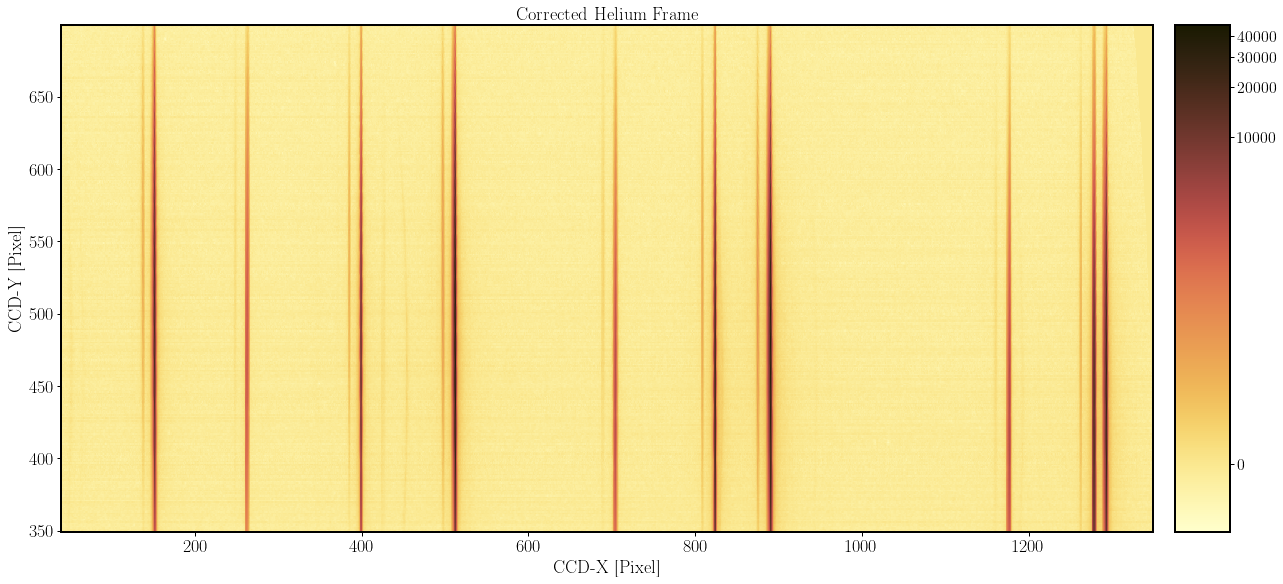

In [58]:
fig, ax = plt.subplots(figsize=(16,8),constrained_layout=True)
im = ax.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            helium_trans_mapcoor,norm=norm,cmap=cmcm.lajolla,rasterized=True)
ax.tick_params(labelsize=18)
ax.set_xlabel("CCD-X [Pixel]",fontsize=18)
ax.set_ylabel("CCD-Y [Pixel]",fontsize=18)
ax.set_title("Corrected Helium Frame",fontsize=18)
clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('',fontsize=16)

In [59]:
hydrogen_trans_mapcoor = ndimage.map_coordinates(hydrogen_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),
                        order=1)

Text(0, 0.5, '')

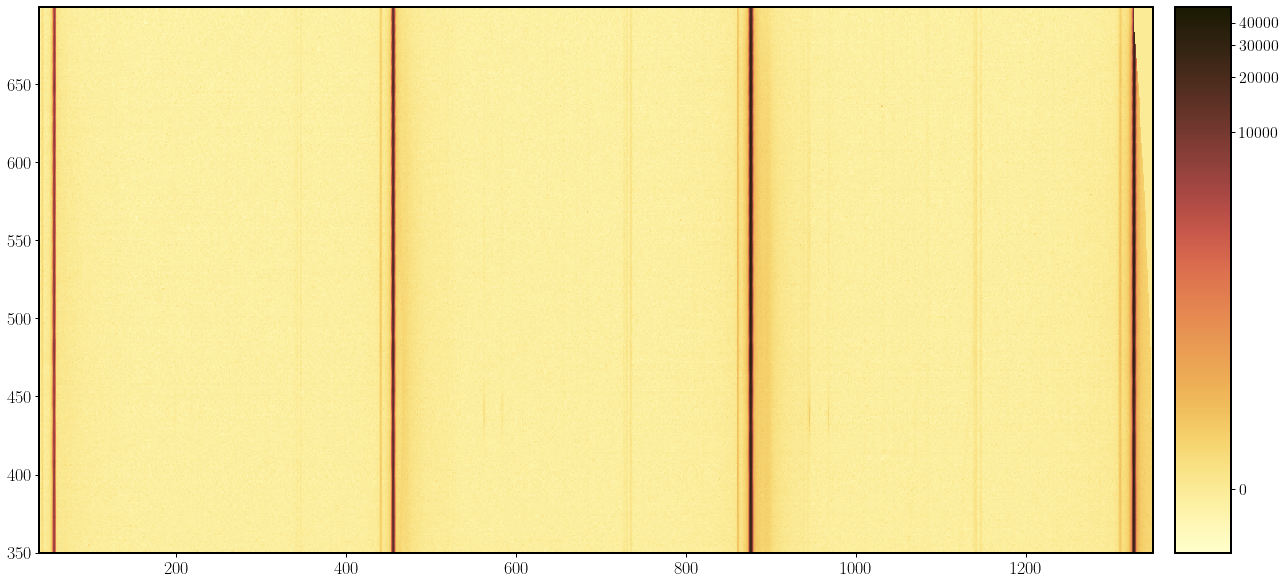

In [60]:
fig, ax = plt.subplots(figsize=(16,8),constrained_layout=True)
im = ax.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            hydrogen_trans_mapcoor,norm=norm_hydrogen,cmap=cmcm.lajolla,rasterized=True)
ax.tick_params(labelsize=18)

clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('',fontsize=16)

In [61]:
mylar_im_collection = ImageFileCollection(red_path,
                            glob_include="SunMylarRedpoint1s_740*.fit")
mylar_im_df = mylar_im_collection.summary.to_pandas()

In [62]:
mylar_image_cube = np.zeros((1040,1392,10))

for ii, row_ in mylar_im_df.iterrows():
    mylar_image_cube[:,:,ii] = CCDData.read(os.path.join(red_path,row_["file"]),unit="adu").data - bias_dc_red_1s

mylar_im_aver = np.mean(mylar_image_cube,axis=2)

In [63]:
mylar_trans_mapcoor = ndimage.map_coordinates(mylar_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),order=1)

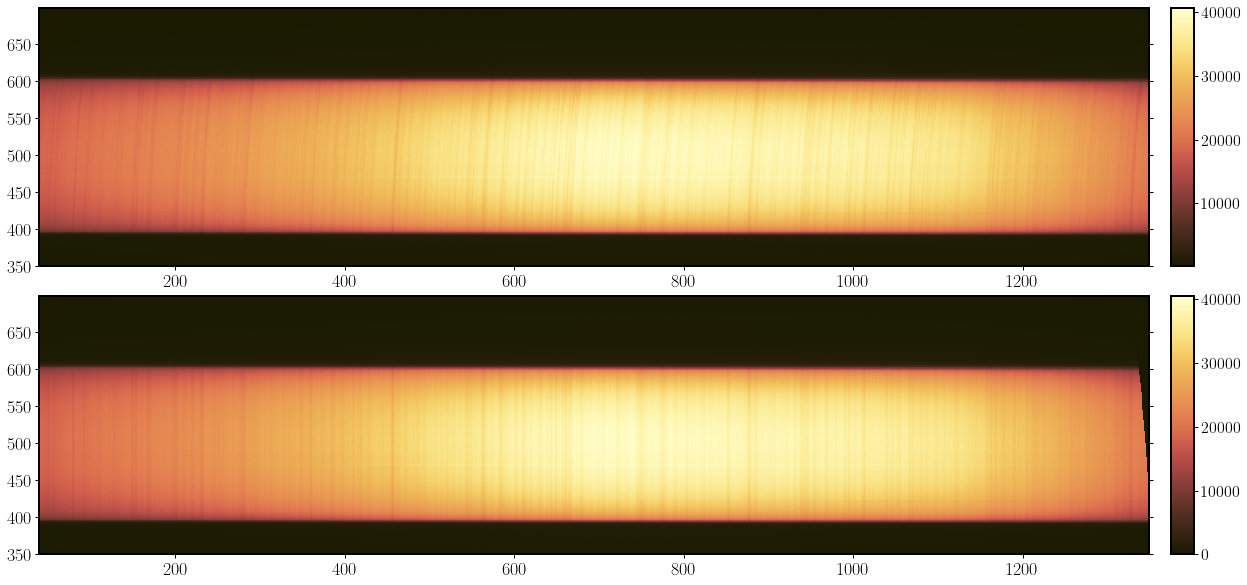

In [64]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)
im1 = ax1.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            mylar_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],cmap=cmcm.lajolla_r,rasterized=True)
im2 = ax2.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            mylar_trans_mapcoor,cmap=cmcm.lajolla_r,rasterized=True)

for ax_, im_ in zip((ax1,ax2),(im1, im2)):
    ax_.tick_params(labelsize=18,right=True)
    clb_ax = inset_axes(ax_,width="2%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax_.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im_,orientation='vertical',ax=ax_,cax=clb_ax)
    clb_ax.tick_params(labelsize=16)
    clb_ax.yaxis.get_offset_text().set_fontsize(16)
    clb_ax.set_ylabel('',fontsize=16)

Text(0, 0.5, '')

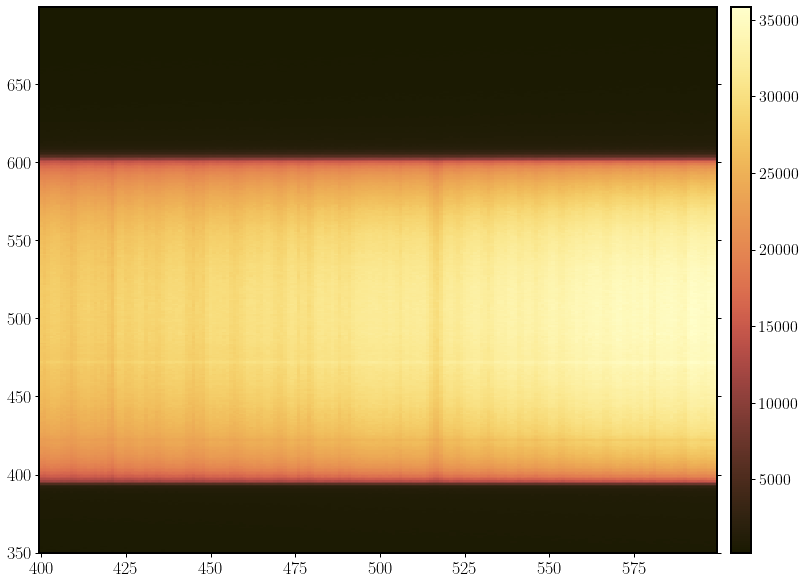

In [65]:
fig, ax = plt.subplots(figsize=(10,8),constrained_layout=True)
im = ax.pcolormesh(np.arange(400,600),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            mylar_trans_mapcoor[:,300:500],cmap=cmcm.lajolla_r,rasterized=True)
ax.tick_params(labelsize=18,right=True)
clb_ax = inset_axes(ax,width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('',fontsize=16)

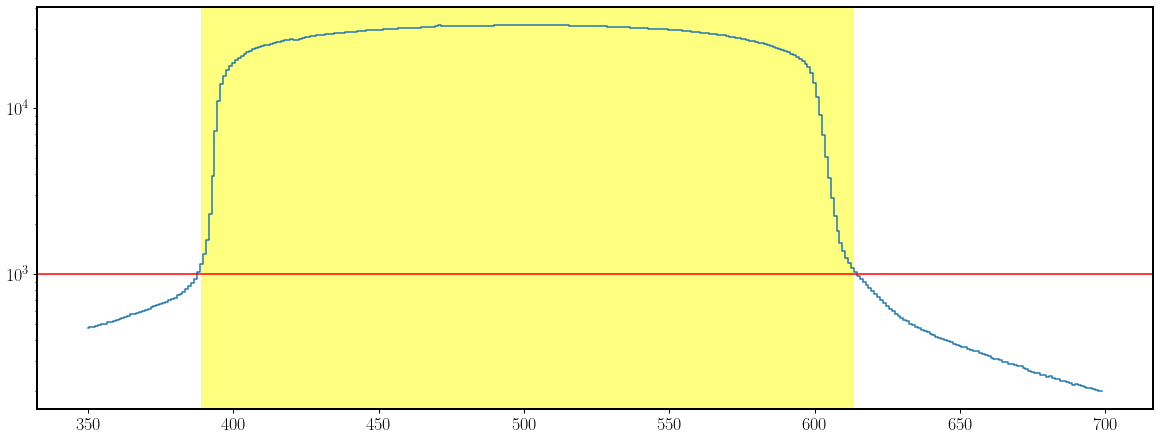

In [66]:
fig, ax = plt.subplots(figsize=(16,6),constrained_layout=True)
ax.step(np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            np.mean(mylar_trans_mapcoor,axis=1),where="mid")
ax.set_yscale("log")
ax.axvspan(389,613,alpha=0.5,color="yellow")
ax.axhline(1e3,color="red")
ax.tick_params(labelsize=18)

(3.0, 400.0)

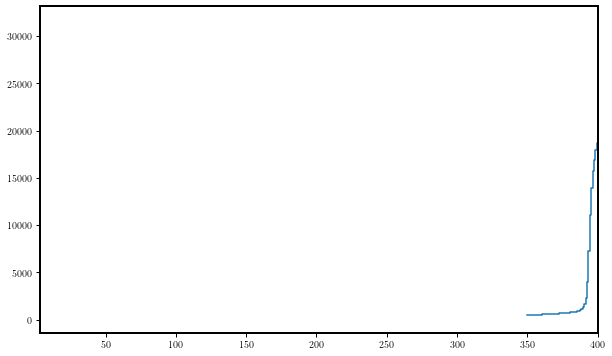

In [67]:
fig, ax = plt.subplots(figsize=(10,6))
ax.step(np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            np.mean(mylar_trans_mapcoor,axis=1),where="mid")
ax.set_xlim(3,400)

In [68]:
fname_skyflat_red_1s = ["SkyRed1s_6141.fit","SkyRed1s_6142.fit","SkyRed1s_6143.fit","SkyRed1s_6144.fit",
                        "SkyRed1s_6145.fit","SkyRed1s_6146.fit","SkyRed1s_6147.fit","SkyRed1s_6148.fit",
                        "SkyRed1s_6149.fit","SkyRed1s_6150.fit","SkyRed1s_6151.fit","SkyRed1s_6152.fit",
                        "SkyRed1s_6153.fit","SkyRed1s_6154.fit","SkyRed1s_6155.fit"]

skyflat_im_collection = ImageFileCollection(red_path,
                            filenames=fname_skyflat_red_1s)
skyflat_im_df = skyflat_im_collection.summary.to_pandas()
skyflat_im_df

file  simple  bitpix  naxis  naxis1  naxis2    bzero  bscale  \
0   SkyRed1s_6141.fit    True      16      2    1392    1040  32768.0     1.0   
1   SkyRed1s_6142.fit    True      16      2    1392    1040  32768.0     1.0   
2   SkyRed1s_6143.fit    True      16      2    1392    1040  32768.0     1.0   
3   SkyRed1s_6144.fit    True      16      2    1392    1040  32768.0     1.0   
4   SkyRed1s_6145.fit    True      16      2    1392    1040  32768.0     1.0   
5   SkyRed1s_6146.fit    True      16      2    1392    1040  32768.0     1.0   
6   SkyRed1s_6147.fit    True      16      2    1392    1040  32768.0     1.0   
7   SkyRed1s_6148.fit    True      16      2    1392    1040  32768.0     1.0   
8   SkyRed1s_6149.fit    True      16      2    1392    1040  32768.0     1.0   
9   SkyRed1s_6150.fit    True      16      2    1392    1040  32768.0     1.0   
10  SkyRed1s_6151.fit    True      16      2    1392    1040  32768.0     1.0   
11  SkyRed1s_6152.fit    True      16      2    1392    1040  32768.0     1.0   
12  SkyRed1s_6153.fit    True      16      2    1392    1040  32768.0     1.0   
13  SkyRed1s_6154.fit    True      16      2    1392    1040  32768.0     1.0   
14  SkyRed1s_6155.fit    True      16      2    1392    1040  32768.0     1.0   

    datamin  datamax  ... ypixsz  xbinning ybinning  xorgsubf  yorgsubf  \
0       0.0  65535.0  ...   6.45         1        1         0         0   
1       0.0  65535.0  ...   6.45         1        1         0         0   
2       0.0  65535.0  ...   6.45         1        1         0         0   
3       0.0  65535.0  ...   6.45         1        1         0         0   
4       0.0  65535.0  ...   6.45         1        1         0         0   
5       0.0  65535.0  ...   6.45         1        1         0         0   
6       0.0  65535.0  ...   6.45         1        1         0         0   
7       0.0  65535.0  ...   6.45         1        1         0         0   
8       0.0  65535.0  ...   6.45         1        1         0         0   
9       0.0  65535.0  ...   6.45         1        1         0         0   
10      0.0  65535.0  ...   6.45         1        1         0         0   
11      0.0  65535.0  ...   6.45         1        1         0         0   
12      0.0  65535.0  ...   6.45         1        1         0         0   
13      0.0  65535.0  ...   6.45         1        1         0         0   
14      0.0  65535.0  ...   6.45         1        1         0         0   

    xpossubf  ypossubf  cblack  cwhite         swcreate  
0          0         0     824    4753  Artemis Capture  
1          0         0     819    4756  Artemis Capture  
2          0         0     817    4760  Artemis Capture  
3          0         0     819    4756  Artemis Capture  
4          0         0     817    4753  Artemis Capture  
5          0         0     817    4750  Artemis Capture  
6          0         0     822    4754  Artemis Capture  
7          0         0     823    4757  Artemis Capture  
8          0         0     820    4757  Artemis Capture  
9          0         0     818    4749  Artemis Capture  
10         0         0     816    4745  Artemis Capture  
11         0         0     813    4752  Artemis Capture  
12         0         0     819    4748  Artemis Capture  
13         0         0     820    4751  Artemis Capture  
14         0         0     818    4751  Artemis Capture  

[15 rows x 24 columns]

In [69]:
skyflat_image_cube = np.zeros((1040,1392,15))

for ii, row_ in skyflat_im_df.iterrows():
    skyflat_image_cube[:,:,ii] = CCDData.read(os.path.join(red_path,row_["file"]),unit="adu").data - bias_dc_red_1s

skyflat_im_aver = np.mean(skyflat_image_cube,axis=2)

In [70]:
skyflat_trans_mapcoor = ndimage.map_coordinates(skyflat_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),
                        order=1)

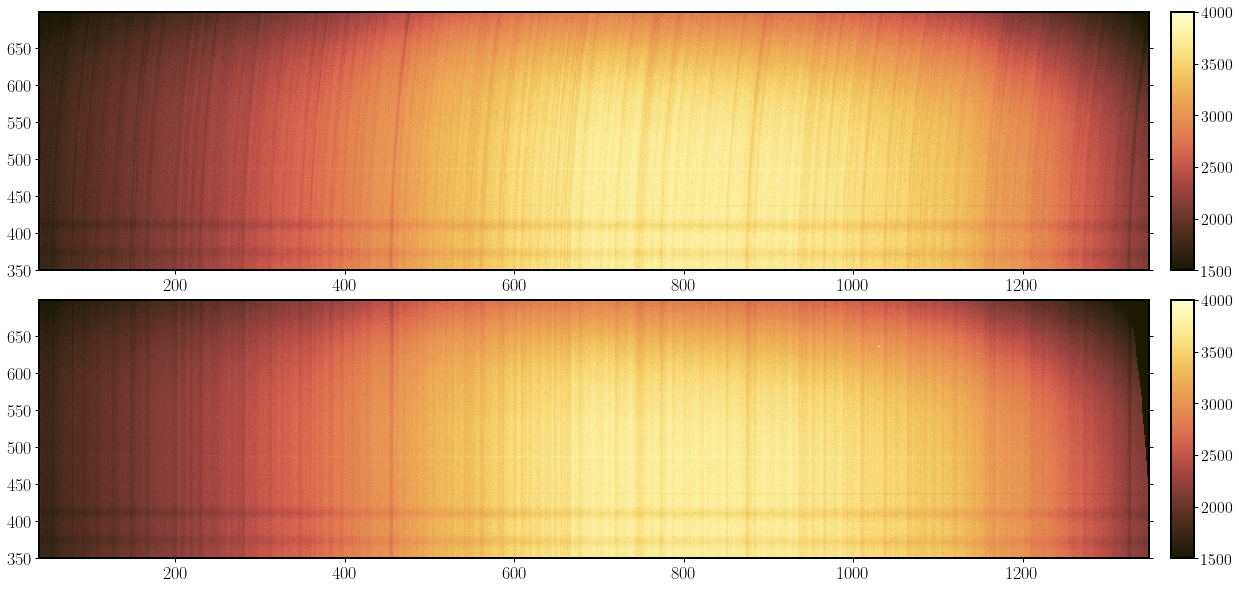

In [71]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)
im1 = ax1.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            skyflat_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],cmap=cmcm.lajolla_r,rasterized=True,vmin=1500,vmax=4000)
im2 = ax2.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            skyflat_trans_mapcoor,cmap=cmcm.lajolla_r,rasterized=True,vmin=1500,vmax=4000)

for ax_, im_ in zip((ax1,ax2),(im1, im2)):
    ax_.tick_params(labelsize=18,right=True)
    clb_ax = inset_axes(ax_,width="2%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax_.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im_,orientation='vertical',ax=ax_,cax=clb_ax)
    clb_ax.tick_params(labelsize=16)
    clb_ax.yaxis.get_offset_text().set_fontsize(16)
    clb_ax.set_ylabel('',fontsize=16)
plt.savefig(fname="../../figs/calib/skyflat_curvature_corr.png",format="png",dpi=150,bbox_inches="tight")

In [72]:
totality_image = CCDData.read(os.path.join(red_path,"TotalitySequenceRed_7723.fit"),unit="adu").data - bias_dc_red_1s

In [73]:
totality_trans_mapcoor = ndimage.map_coordinates(totality_image[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),
                                                order=1)

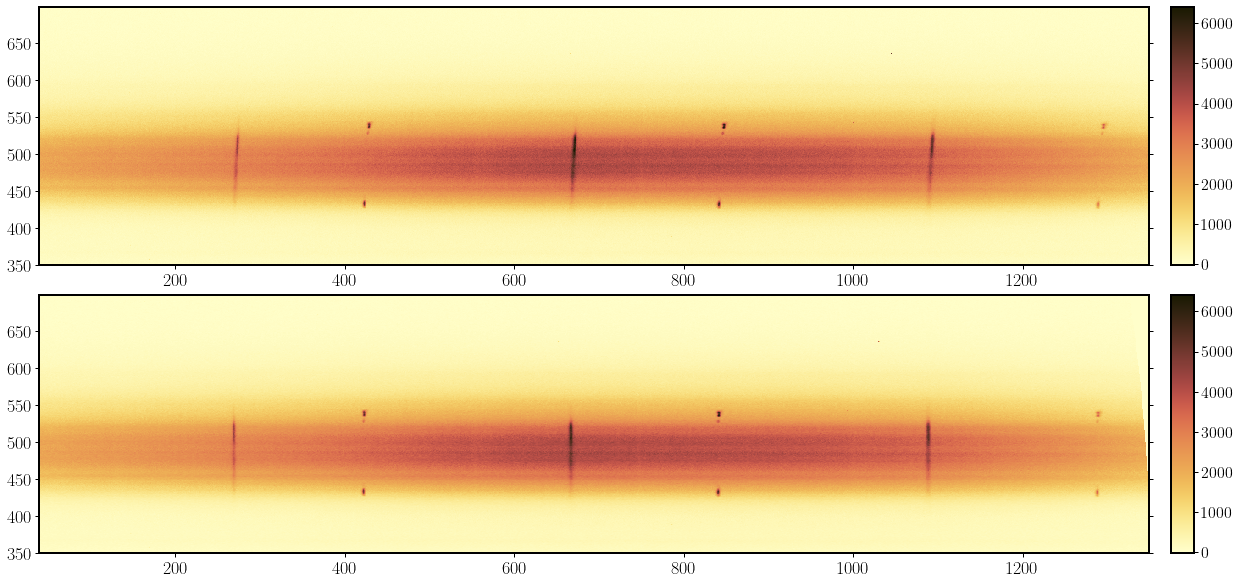

In [74]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)
im1 = ax1.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            totality_image[testy_slice_mapcoor, testx_slice_mapcoor],cmap=cmcm.lajolla,rasterized=True)
im2 = ax2.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            totality_trans_mapcoor,cmap=cmcm.lajolla,rasterized=True)

for ax_, im_ in zip((ax1,ax2),(im1, im2)):
    ax_.tick_params(labelsize=18,right=True)
    clb_ax = inset_axes(ax_,width="2%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax_.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im_,pad = 0.05,orientation='vertical',ax=ax_,cax=clb_ax)
    clb_ax.tick_params(labelsize=16)
    clb_ax.yaxis.get_offset_text().set_fontsize(16)
    clb_ax.set_ylabel('',fontsize=16)

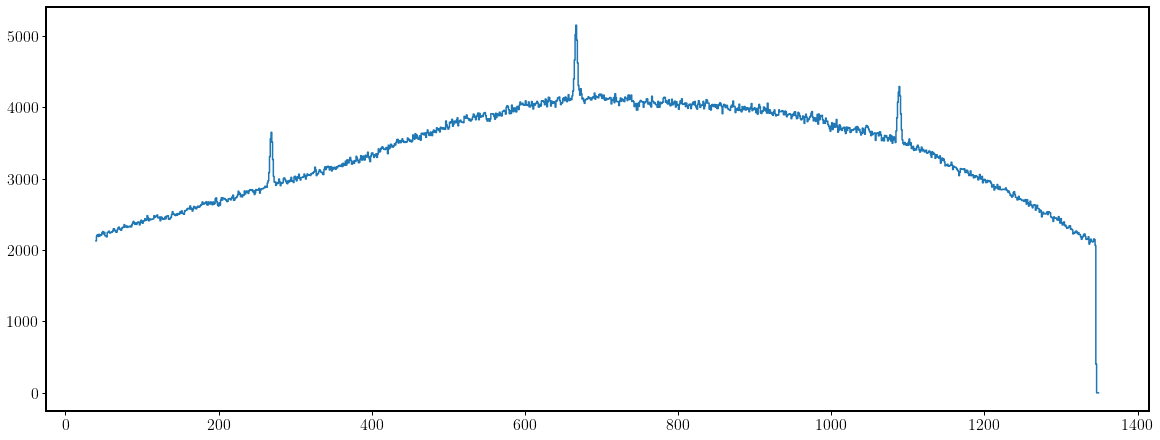

In [75]:
totality_spectrum_1d = np.mean(totality_trans_mapcoor[130:140,:],axis=0)
fig, ax = plt.subplots(figsize=(16,6),constrained_layout=True)
ax.step(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),totality_spectrum_1d,where="mid")
ax.tick_params(labelsize=16)

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:205: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


<AxesSubplot:ylabel='Intensity'>

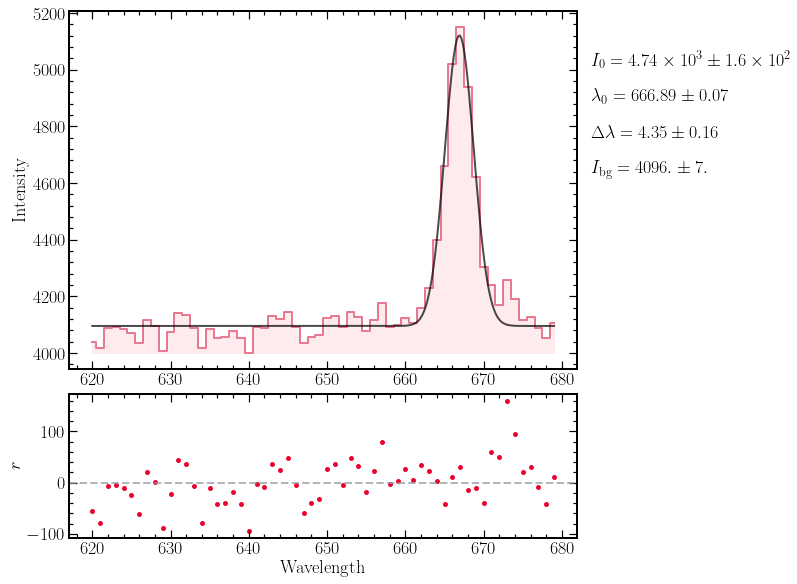

In [76]:
totality_spectrum_1d_zoomin_slice = slice(580,640)
totality_spectrum_1d_zoomin = totality_spectrum_1d[totality_spectrum_1d_zoomin_slice]
totality_spectrum_1d_x = np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop)[totality_spectrum_1d_zoomin_slice]

totality_spectrum_corr_fit = SpectrumFitSingle(data=totality_spectrum_1d_zoomin,wvl=totality_spectrum_1d_x,line_number=1,
                                            line_wvl_init=665,int_max_init=1200,fwhm_init=5,same_width=False,
                                        )
totality_spectrum_corr_fit.run_lse()                                    
totality_spectrum_corr_fit.plot(plot_fit=True)

In [77]:
with h5py.File("../../sav/Eclipse/Curvature/master_curvature_red.h5", 'w') as hf:
    df_x = hf.create_dataset("xpos_map_coordinate",  data=xpos_map_coordinate)
    df_y = hf.create_dataset("ypos_map_coordinate",  data=ypos_map_coordinate)
    df_x.attrs["xstart_pixel"] = testx_slice_mapcoor.start
    df_x.attrs["xend_pixel"] = testx_slice_mapcoor.stop
    df_y.attrs["ystart_pixel"] = testy_slice_mapcoor.start
    df_y.attrs["yend_pixel"] = testy_slice_mapcoor.stop